Based on these posts: 
* https://medium.com/@chrisfotache/text-classification-in-python-pipelines-nlp-nltk-tf-idf-xgboost-and-more-b83451a327e0
* https://github.com/keisukeirie/Amazon_review_helpfulness_prediction
* https://stackabuse.com/text-classification-with-bert-tokenizer-and-tf-2-0-in-python/
* https://towardsdatascience.com/simple-bert-using-tensorflow-2-0-132cb19e9b22

In [1]:
!pip install -q boto3
!pip install -q xgboost==0.90
!pip install -q scikit-learn==0.20.3
!pip install -q nltk==3.4.5

tensorflow 2.0.0 requires opt-einsum>=2.3.2, which is not installed.
tensorflow 2.0.0 has requirement gast==0.2.2, but you'll have gast 0.3.3 which is incompatible.
awscli 1.18.11 has requirement botocore==1.15.11, but you'll have botocore 1.14.17 which is incompatible.
You are using pip version 10.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
tensorflow 2.0.0 requires opt-einsum>=2.3.2, which is not installed.
tensorflow 2.0.0 has requirement gast==0.2.2, but you'll have gast 0.3.3 which is incompatible.
awscli 1.18.11 has requirement botocore==1.15.11, but you'll have botocore 1.14.17 which is incompatible.
You are using pip version 10.0.1, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
tensorflow 2.0.0 requires opt-einsum>=2.3.2, which is not installed.
tensorflow 2.0.0 has requirement gast==0.2.2, but you'll have gast 0.3.3 which is incompatible.
a

In [1]:
import boto3
import sagemaker
import pandas as pd

sess   = sagemaker.Session()
bucket = sess.default_bucket()
role = sagemaker.get_execution_role()
region = boto3.Session().region_name

#sm = boto3.Session().client(service_name='sagemaker', region_name=region)

In [2]:
!head ./data/amazon90000.tsv

marketplace	customer_id	review_id	product_id	product_parent	product_title	product_category	star_rating	helpful_votes	total_votes	vine	verified_purchase	review_headline	review_body	review_date
US	12190288	R3FU16928EP5TC	B00AYB1482	668895143	Enlightened: Season 1	Digital_Video_Download	5	0	0	N	Y	I loved it and I wish there was a season 3	I loved it and I wish there was a season 3... I watched season 2 and loved that as well!	2015-08-31
US	30549954	R1IZHHS1MH3AQ4	B00KQD28OM	246219280	Vicious	Digital_Video_Download	5	0	0	N	Y	As always it seems that the best shows come from England	As always it seems that the best shows come from England. best of the best without words, i cant wait to watch season two.	2015-08-31
US	52895410	R52R85WC6TIAH	B01489L5LQ	534732318	After Words	Digital_Video_Download	4	17	18	N	Y	Charming movie	This movie isn't perfect, but it gets a lot of things right. Yes, the librarian character played by Marcia Gay Harden is stereotypical and played a bit heavy-handed. But the

In [3]:
df = pd.read_csv('./data/amazon90000.tsv', delimiter='\t')
df.shape

(88395, 15)

In [4]:
df.head(5)

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,12190288,R3FU16928EP5TC,B00AYB1482,668895143,Enlightened: Season 1,Digital_Video_Download,5,0,0,N,Y,I loved it and I wish there was a season 3,I loved it and I wish there was a season 3... ...,2015-08-31
1,US,30549954,R1IZHHS1MH3AQ4,B00KQD28OM,246219280,Vicious,Digital_Video_Download,5,0,0,N,Y,As always it seems that the best shows come fr...,As always it seems that the best shows come fr...,2015-08-31
2,US,52895410,R52R85WC6TIAH,B01489L5LQ,534732318,After Words,Digital_Video_Download,4,17,18,N,Y,Charming movie,"This movie isn't perfect, but it gets a lot of...",2015-08-31
3,US,27072354,R7HOOYTVIB0DS,B008LOVIIK,239012694,Masterpiece: Inspector Lewis Season 5,Digital_Video_Download,5,0,0,N,Y,Five Stars,excellant this is what tv should be,2015-08-31
4,US,26939022,R1XQ2N5CDOZGNX,B0094LZMT0,535858974,On The Waterfront,Digital_Video_Download,5,0,0,N,Y,Brilliant film from beginning to end,Brilliant film from beginning to end. All of t...,2015-08-31


# TODO:  Clean commas from raw text

In [5]:
df_scrubbed = df

df_scrubbed['marketplace'].replace(',', ' ')
df_scrubbed['review_id'].replace(',', ' ')
df_scrubbed['product_id'].replace(',', ' ')
df_scrubbed['product_title'].replace(',', ' ')
df_scrubbed['product_category'].replace(',', ' ')
df_scrubbed['review_headline'].replace(',', ' ')
df_scrubbed['review_body'].replace(',', ' ')
df_scrubbed['review_date'].replace(',', ' ')

df_scrubbed.shape

(88395, 15)

In [6]:
df_scrubbed.head(5)

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,12190288,R3FU16928EP5TC,B00AYB1482,668895143,Enlightened: Season 1,Digital_Video_Download,5,0,0,N,Y,I loved it and I wish there was a season 3,I loved it and I wish there was a season 3... ...,2015-08-31
1,US,30549954,R1IZHHS1MH3AQ4,B00KQD28OM,246219280,Vicious,Digital_Video_Download,5,0,0,N,Y,As always it seems that the best shows come fr...,As always it seems that the best shows come fr...,2015-08-31
2,US,52895410,R52R85WC6TIAH,B01489L5LQ,534732318,After Words,Digital_Video_Download,4,17,18,N,Y,Charming movie,"This movie isn't perfect, but it gets a lot of...",2015-08-31
3,US,27072354,R7HOOYTVIB0DS,B008LOVIIK,239012694,Masterpiece: Inspector Lewis Season 5,Digital_Video_Download,5,0,0,N,Y,Five Stars,excellant this is what tv should be,2015-08-31
4,US,26939022,R1XQ2N5CDOZGNX,B0094LZMT0,535858974,On The Waterfront,Digital_Video_Download,5,0,0,N,Y,Brilliant film from beginning to end,Brilliant film from beginning to end. All of t...,2015-08-31


# Drop NaNs

In [7]:
df_scrubbed.isna().values.any()

True

In [8]:
df_scrubbed = df.dropna()
df_scrubbed = df_scrubbed.reset_index(drop=True)
#df_scrubbed = df_scrubbed.drop(labels=['index'], axis=1)
df_scrubbed.shape

(88391, 15)

In [9]:
df_scrubbed.head(5)

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,12190288,R3FU16928EP5TC,B00AYB1482,668895143,Enlightened: Season 1,Digital_Video_Download,5,0,0,N,Y,I loved it and I wish there was a season 3,I loved it and I wish there was a season 3... ...,2015-08-31
1,US,30549954,R1IZHHS1MH3AQ4,B00KQD28OM,246219280,Vicious,Digital_Video_Download,5,0,0,N,Y,As always it seems that the best shows come fr...,As always it seems that the best shows come fr...,2015-08-31
2,US,52895410,R52R85WC6TIAH,B01489L5LQ,534732318,After Words,Digital_Video_Download,4,17,18,N,Y,Charming movie,"This movie isn't perfect, but it gets a lot of...",2015-08-31
3,US,27072354,R7HOOYTVIB0DS,B008LOVIIK,239012694,Masterpiece: Inspector Lewis Season 5,Digital_Video_Download,5,0,0,N,Y,Five Stars,excellant this is what tv should be,2015-08-31
4,US,26939022,R1XQ2N5CDOZGNX,B0094LZMT0,535858974,On The Waterfront,Digital_Video_Download,5,0,0,N,Y,Brilliant film from beginning to end,Brilliant film from beginning to end. All of t...,2015-08-31


In [10]:
df_scrubbed['is_positive_sentiment'] = (df_scrubbed['star_rating'] >= 4).astype(int)
#df_labeled = df_scrubbed #[['is_positive_sentiment', 'review_body']]
#df_labeled.head(5)

In [11]:
#df_scrubbed.insert(0, 'is_positive_sentiment', df_labels)
#df_labeled = df_scrubbed

In [12]:
df_scrubbed.head(5)

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date,is_positive_sentiment
0,US,12190288,R3FU16928EP5TC,B00AYB1482,668895143,Enlightened: Season 1,Digital_Video_Download,5,0,0,N,Y,I loved it and I wish there was a season 3,I loved it and I wish there was a season 3... ...,2015-08-31,1
1,US,30549954,R1IZHHS1MH3AQ4,B00KQD28OM,246219280,Vicious,Digital_Video_Download,5,0,0,N,Y,As always it seems that the best shows come fr...,As always it seems that the best shows come fr...,2015-08-31,1
2,US,52895410,R52R85WC6TIAH,B01489L5LQ,534732318,After Words,Digital_Video_Download,4,17,18,N,Y,Charming movie,"This movie isn't perfect, but it gets a lot of...",2015-08-31,1
3,US,27072354,R7HOOYTVIB0DS,B008LOVIIK,239012694,Masterpiece: Inspector Lewis Season 5,Digital_Video_Download,5,0,0,N,Y,Five Stars,excellant this is what tv should be,2015-08-31,1
4,US,26939022,R1XQ2N5CDOZGNX,B0094LZMT0,535858974,On The Waterfront,Digital_Video_Download,5,0,0,N,Y,Brilliant film from beginning to end,Brilliant film from beginning to end. All of t...,2015-08-31,1


In [13]:
import seaborn as sns

sns.countplot(x='is_positive_sentiment', data=df_scrubbed)


# Balance the Dataset between Classes

In [14]:
from sklearn.utils import resample

is_negative_sentiment_df = df_scrubbed.query('is_positive_sentiment == 0')
is_positive_sentiment_df = df_scrubbed.query('is_positive_sentiment == 1')

# TODO:  check which sentiment has the least number of samples

is_positive_downsampled_df = resample(is_positive_sentiment_df,
                                      replace = False,
                                      n_samples = len(is_negative_sentiment_df),
                                      random_state = 27)

df_balanced = pd.concat([is_negative_sentiment_df, is_positive_downsampled_df])
df_balanced = df_balanced.reset_index(drop=True)

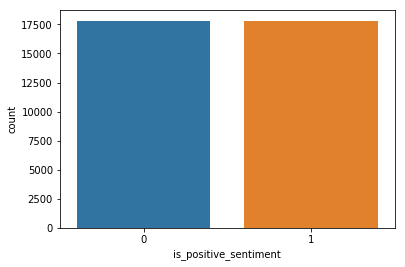

In [15]:
sns.countplot(x='is_positive_sentiment', data=df_balanced)


In [16]:
# $S3_BUCKET/feature-store/amazon-reviews/balanced/data.csv

prefix = 'feature-store/amazon-reviews/balanced'

balanced_path = './{}/data.csv'.format(prefix)

import os
os.makedirs(prefix, exist_ok=True)

df_balanced.to_csv(balanced_path, index=False, header=True)


# Upload to S3

In [17]:
df_balanced_s3_uri = sess.upload_data(path=balanced_path, key_prefix=prefix)

print(df_balanced_s3_uri)


s3://sagemaker-us-east-1-835319576252/feature-store/amazon-reviews/balanced/data.csv


# TF/IDF Feature Engineering

### Create X (features) and y (labels)

In [18]:
df_X = df_balanced[['review_body']]
df_y = df_balanced['is_positive_sentiment']

print('X.shape:  {}'.format(df_X.shape))
print('y.shape:  {}'.format(df_y.shape))

X.shape:  (35616, 1)
y.shape:  (35616,)


In [19]:
# scikit-Learn==0.20.3
# nltk==3.4.5

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import SGDClassifier
from sklearn.base import BaseEstimator, TransformerMixin

import nltk
import re

class TextSelector(BaseEstimator, TransformerMixin):
    def __init__(self, field):
        self.field = field
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.field]
    
def Tokenizer(str_input):
    words = re.sub(r"[^A-Za-z0-9\-]", " ", str_input).lower().split()
    porter_stemmer=nltk.PorterStemmer()
    words = [porter_stemmer.stem(word) for word in words]
    return words

feature_union = FeatureUnion([
    ('body', Pipeline([
        ('body_text_selector', TextSelector('review_body')),
        ('tfidf_vectorizer', TfidfVectorizer(tokenizer=Tokenizer, 
                                             stop_words="english",
                                             min_df=.0025, 
                                             max_df=0.25, 
                                             ngram_range=(1,3))),
        ('svd', TruncatedSVD(algorithm='randomized', n_components=300)),
    ]))
])

In [20]:
np_tfidf = feature_union.fit_transform(df_X)
np_tfidf.shape

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/feature_extraction/text.py:301: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not

(35616, 300)

In [21]:
df_tfidf = pd.DataFrame(np_tfidf)
df_tfidf.insert(0, 'is_positive_sentiment', df_y)
df_tfidf.shape

(35616, 301)

# Split into `train`, `validation`, and `test`

In [22]:
from sklearn.model_selection import train_test_split

# Split all data into 90% train and 10% holdout
df_tfidf_train, df_tfidf_holdout = train_test_split(df_tfidf, test_size=0.1, random_state=0)
# Split holdout data into 50% validation and 50% test
df_tfidf_validation, df_tfidf_test = train_test_split(df_tfidf_holdout, test_size=0.5, random_state=0)

print('df_tfidf.shape={}'.format(df_tfidf.shape))
print('df_tfidf_train.shape={}'.format(df_tfidf_train.shape))
print('df_tfidf_validation.shape={}'.format(df_tfidf_validation.shape))
print('df_tfidf_test.shape={}'.format(df_tfidf_test.shape))

# print('X_train.shape={}'.format(df_X_tfidf_train.shape))
# print('y_train.shape={}'.format(df_y_train.shape))

# print('X_validation.shape={}'.format(df_X_tfidf_validation.shape))
# print('y_validation.shape={}'.format(df_y_validation.shape))

# print('X_test.shape={}'.format(df_X_tfidf_test.shape))
# print('y_test.shape={}'.format(df_y_test.shape))

# # Split all data into 90% train and 10% holdout
# df_X_tfidf_train, df_X_tfidf_holdout, df_y_train, df_y_holdout = train_test_split(df_X_tfidf, df_y, test_size=0.1, random_state=0)
# # Split holdout data into 50% validation and 50% test
# df_X_tfidf_validation, df_X_tfidf_test, df_y_validation, df_y_test = train_test_split(df_X_tfidf_holdout, df_y_holdout, test_size=0.5, random_state=0)

# print('X.shape={}'.format(df_X_tfidf.shape))
# print('y.shape={}'.format(df_y.shape))

# print('X_train.shape={}'.format(df_X_tfidf_train.shape))
# print('y_train.shape={}'.format(df_y_train.shape))

# print('X_validation.shape={}'.format(df_X_tfidf_validation.shape))
# print('y_validation.shape={}'.format(df_y_validation.shape))

# print('X_test.shape={}'.format(df_X_tfidf_test.shape))
# print('y_test.shape={}'.format(df_y_test.shape))


df_tfidf.shape=(35616, 301)
df_tfidf_train.shape=(32054, 301)
df_tfidf_validation.shape=(1781, 301)
df_tfidf_test.shape=(1781, 301)


In [23]:
df_tfidf_train.head(5)

,is_positive_sentiment,0,1,2,3,4,5,6,7,8,...,290,291,292,293,294,295,296,297,298,299
1925,0,0.180635,-0.056508,-0.223100,0.119096,-0.127045,-0.060230,0.220665,0.002692,-0.136736,...,0.035531,0.003230,0.049746,-0.024436,0.008697,-0.040409,0.049023,-0.021682,0.017212,0.037025
16340,0,0.000000,-0.000000,-0.000000,-0.000000,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,...,0.000000,-0.000000,-0.000000,-0.000000,-0.000000,0.000000,0.000000,-0.000000,0.000000,-0.000000
22024,1,0.213930,0.260375,0.081973,0.006272,-0.078772,-0.013147,-0.023387,-0.007294,0.005259,...,0.004378,-0.015701,-0.004516,0.003505,0.020865,-0.004005,-0.047265,0.006801,0.057051,-0.038034
30124,1,0.217635,0.346261,0.127182,0.073634,-0.052092,0.005775,-0.010056,-0.005239,0.015079,...,0.007468,-0.002249,0.006923,0.001443,-0.005906,0.001420,-0.001224,0.003572,-0.008933,0.001775
1215,0,0.113655,-0.055001,-0.018477,-0.106168,-0.037306,-0.016887,-0.040407,-0.007593,0.020489,...,0.001191,0.010132,-0.006848,-0.003783,-0.017766,-0.000540,0.004517,0.007619,0.000562,0.015903


In [24]:
# $S3_BUCKET/feature-store/amazon-reviews/balanced-tfidf/data.csv

prefix_train = 'feature-store/amazon-reviews/balanced-tfidf/train'
prefix_validation = 'feature-store/amazon-reviews/balanced-tfidf/validation'
prefix_test = 'feature-store/amazon-reviews/balanced-tfidf/test'

balanced_tfidf_train_path = './{}/data.csv'.format(prefix_train)
balanced_tfidf_validation_path = './{}/data.csv'.format(prefix_validation)
balanced_tfidf_test_path = './{}/data.csv'.format(prefix_test)

import os
os.makedirs(prefix_train, exist_ok=True)
os.makedirs(prefix_validation, exist_ok=True)
os.makedirs(prefix_test, exist_ok=True)


In [25]:
df_tfidf_train.to_csv(balanced_tfidf_train_path, index=False, header=True)
df_tfidf_validation.to_csv(balanced_tfidf_validation_path, index=False, header=True)
df_tfidf_test.to_csv(balanced_tfidf_test_path, index=False, header=True)


In [26]:
df_balanced_tfidf_train_s3_uri = sess.upload_data(path=balanced_tfidf_train_path, key_prefix=prefix_train)
df_balanced_tfidf_validation_s3_uri = sess.upload_data(path=balanced_tfidf_train_path, key_prefix=prefix_validation)
df_balanced_tfidf_test_s3_uri = sess.upload_data(path=balanced_tfidf_train_path, key_prefix=prefix_test)

print(df_balanced_tfidf_train_s3_uri)
print(df_balanced_tfidf_validation_s3_uri)
print(df_balanced_tfidf_test_s3_uri)


s3://sagemaker-us-east-1-835319576252/feature-store/amazon-reviews/balanced-tfidf/train/data.csv
s3://sagemaker-us-east-1-835319576252/feature-store/amazon-reviews/balanced-tfidf/validation/data.csv
s3://sagemaker-us-east-1-835319576252/feature-store/amazon-reviews/balanced-tfidf/test/data.csv


In [28]:
!aws s3 ls $prefix_train/


An error occurred (AccessDenied) when calling the ListObjectsV2 operation: Access Denied
